In [44]:
import numpy as np
import sys
from scipy.stats import entropy
from scipy.special import rel_entr
from scipy.spatial.distance import cdist
import torch,torch.optim, torch.nn
import sklearn.datasets

In [150]:
def get_p_scores(X, perp, need_conditionals = False):
    
    N = len(X)
    
    target_h = np.log(perp)
    
    betas_max = np.ones(N)
    betas_min = np.ones(N)
    betas = np.ones(N)
    
    betas_max[:] = 10000
    betas_min[:] = 1
    
    betas[:] = (betas_max + betas_min) / 2
     
    conditionals = get_conditionals(X, betas)
    actual_h = entropy(conditionals, axis = 1)
    
    tolerance = 0.00001
    
    while np.sum(np.abs(actual_h - target_h) > tolerance) > 0:
        
        greater = (actual_h - target_h) > tolerance
        
        betas_max[greater] = betas[greater]
        
        lesser = (actual_h - target_h) < tolerance
        
        betas_min[lesser] = betas[lesser]
        
        need_change = np.abs(actual_h - target_h) > tolerance
        
        betas[need_change] = (betas_max[need_change] + betas_min[need_change]) / 2
        
        conditionals = get_conditionals(X, betas)
        
        actual_h = entropy(conditionals, axis = 1)
        
    probs_sym = (conditionals.T + conditionals) / (2 * len(X))

    return probs_sym

def get_conditionals(X, betas):
    
    dists = (cdist(X, X)**2) / betas[:, None]
    
    exp = np.exp(-dists)
    np.fill_diagonal(exp, 0)
    
    row_sums = np.sum(exp, axis = 1)[:, None]
    exp /= row_sums
    
    return exp

def compute_cost(p_scores, q_scores):
    eps=1e-7
    kl_loss = torch.nn.KLDivLoss(reduction = "sum", log_target = True)
    return kl_loss(torch.log(q_scores + eps), torch.log(p_scores + eps))

#     print(p_scores * (p_scores.log() - q_scores.log()))
#     p_scores += eps
#     return (p_scores * (p_scores.log() - q_scores.log())).sum()

def get_q_scores(Y):
    
    dists = (torch.cdist(Y, Y)**2 + 1) **-1
    dists.fill_diagonal_(0)
    
    if(dists.sum() == 0): 
        print(f"Warning: Dists 0 for y = {Y}")
        
    dists /= dists.sum()
    
    return dists

def init_y(X):
    return torch.tensor(np.random.normal(size = (len(X), 2), scale = 1.0))


In [151]:
dataset = sklearn.datasets.load_digits()

X = dataset['data']
T = dataset['target']
R = np.random.mtrand.RandomState(0).permutation(len(X))[:750]
X = X[R]
T = T[R]

p_scores = torch.tensor(get_p_scores(X, 60))
y = init_y(X)
y.requires_grad_(True)
print(y)

tensor([[ 0.5082,  1.5800],
        [-1.1772, -0.4246],
        [-0.8642, -1.5071],
        ...,
        [-0.5163,  1.9844],
        [ 1.5233, -1.4951],
        [ 0.8830,  0.5073]], dtype=torch.float64, requires_grad=True)


In [152]:
optimizer = torch.optim.SGD((y,), lr=100, momentum=0.95)

In [153]:
for i in range(500):
    # print(y)
    q_scores = get_q_scores(y)
    # print(q_scores)
    optimizer.zero_grad()
    J = compute_cost(p_scores, q_scores)
    print(J.data.numpy())
    
    J.backward()
    
    optimizer.step()
    # print(y)

2.5789777878364806
2.5617660338840325
2.5276169002379723
2.4768846439155694
2.411389803681382
2.336751709706166
2.265855727764859
2.2091396885838703
2.1610590193581096
2.1080532030231436
2.0397450979789324
1.9555674737643929
1.8615943754237645
1.7653262942305443
1.6765522473191914
1.5988444310583134
1.5274995894820502
1.4598331486240466
1.3958846812344343
1.3372323878846961
1.2850784072383798
1.2389910901356171
1.1980420772498381
1.161435777855822
1.1280715167615132
1.0973360436719535
1.069673492059009
1.0457577847306028
1.025548751322015
1.0081295442058942
0.9919936732974978
0.975345253500276
0.9578066875023057
0.9406098249902131
0.9253185187338379
0.911984109931731
0.9001948420350554
0.8897132064994618
0.8800797989652617
0.8711776028767027
0.8634791816631675
0.8568081272882189
0.8505550331517968
0.8443646305688511
0.8380758186066297
0.8316167851180514
0.8252494678969301
0.8193209912196979
0.8138331711938613
0.8085734390720429
0.8034336140671439
0.7985688396145437
0.7942298317160484
0

0.5291323577371898
0.5290907836633514
0.5290490169929127
0.5290071275902862
0.5289652306563857
0.5289234364964617
0.5288818075644801
0.5288403400294519
0.5287989748286616
0.5287576298525274
0.528716236577244
0.5286747644931887
0.5286332243021392
0.5285916517871982
0.5285500830244994
0.5285085342917705
0.5284669960041677
0.5284254418953829
0.528383846791723
0.5283422025392228
0.5283005234801454
0.5282588389664024
0.5282171773316882
0.528175549941956
0.5281339435022943
0.5280923243105389
0.5280506521566697
0.5280088970992315
0.5279670513954589
0.5279251315447616
0.5278831701453847
0.527841201714932
0.5277992488446535
0.5277573143294164
0.5277153818965457
0.5276734243883122
0.5276314153761238
0.5275893392550033
0.527547196023355
0.52750499949129
0.5274627704124373
0.5274205278738142
0.5273782825645961
0.5273360343337834
0.5272937744058193
0.5272514906939428
0.5272091736232014
0.5271668200615521
0.5271244341109799
0.5270820250002033
0.5270396034620015
0.5269971783449008
0.5269547547788063


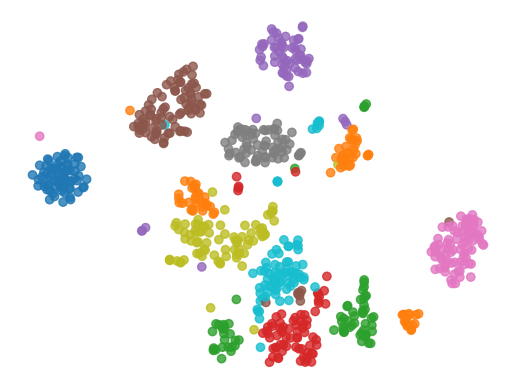

In [154]:
from matplotlib import pyplot as plt

# ax = fig.add_subplot(111)
plt.axis("off")

plt.scatter(y.detach().numpy()[:,0], y.detach().numpy()[:,1], c = T, cmap = "tab10", alpha = 0.8)
plt.savefig("T-SNE.pdf")